In [107]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

In [108]:
rental_df = pd.read_csv("../data/curated/proximity_calc_final.csv", index_col=False)

In [109]:
# Removes costs which were likely scraping errors 
rental_df = rental_df[~(rental_df['cost_text'] <= 100)]  
rental_df = rental_df[~(rental_df['cost_text'] >= 3000)]  
# Drop rows with non-complete proximity calculations
rental_df = rental_df[rental_df.cbd_dur != -1]
rental_df = rental_df[rental_df.train_prox_2km != -1]
rental_df = rental_df[rental_df.recre_prox_2_min != -1]
rental_df = rental_df[rental_df.school_prox_closest != -1]
rental_df = rental_df[rental_df.hosp_closest != -1]




In [111]:
rental_df

,name,prop_type,cost_text,coordinates,add_feat,Beds_no,Baths_no,Parking_no,Acreage / Semi-Rural,Apartment / Unit / Flat,...,school_prox_2_min,school_prox_closest,recre_prox_15km,recre_prox_2_min,recre_prox_closest,shopping_prox_5km,shopping_prox_2_min,shopping_prox_closest,hosp_prox_5km,hosp_closest
0,3309/18 Hoff Boulevard Southbank VIC 3006,Apartment / Unit / Flat,650.0,"[144.9640414, -37.825817]","['built in wardrobes', 'ducted heating']",2,2,0,0,1,...,0,0.76,1010,0,1.25,197,8,0.02,5,3.07
1,5605/70 Southbank Boulevard Southbank VIC 3006,Apartment / Unit / Flat,470.0,"[144.9639881, -37.8231931]","['gas', 'internal laundry', 'intercom', 'floor...",1,1,0,0,1,...,0,1.01,1009,0,1.27,197,8,0.02,5,2.95
2,229/22 Kavanagh Street Southbank VIC 3006,Apartment / Unit / Flat,420.0,"[144.9658569, -37.82284060000001]","['heating', 'balcony deck', 'furnished']",1,1,1,0,1,...,0,0.91,1023,0,1.37,197,8,0.02,5,2.78
3,1112/39 Coventry Street Southbank VIC 3006,Apartment / Unit / Flat,550.0,"[144.9692407, -37.8294033]","['built in wardrobes', 'gas', 'internal laundr...",2,1,1,0,1,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14
4,1913/39 Coventry Street Southbank VIC 3006,Apartment / Unit / Flat,550.0,"[144.9692407, -37.8294033]","['air conditioning', 'built in wardrobes', 'ga...",2,1,1,0,1,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13033,20 Tarooh Street Cape Paterson VIC 3995,House,500.0,"[145.6181208, -38.67034659999999]","['secure parking', 'bath', 'dishwasher', 'shed']",4,2,0,0,0,...,0,7.68,38,3,0.54,196,7,0.02,0,49.98
13034,1/5 Sir Henry Bolte Court Wonthaggi VIC 3995,House,380.0,"[145.5891883, -38.6001766]","['gas', 'secure parking']",2,1,1,0,0,...,0,1.18,41,0,1.13,196,7,0.02,0,40.96
13035,3/37 Dunn Street Wonthaggi VIC 3995,Apartment / Unit / Flat,330.0,"[145.5892931, -38.6137663]","['built in wardrobes', 'internal laundry', 'he...",2,1,1,0,1,...,1,0.81,41,2,0.45,196,7,0.02,0,42.46
13036,59 Billson Street Wonthaggi VIC 3995,House,480.0,"[145.5970984, -38.6151218]","['internal laundry', 'secure parking', 'heating']",3,2,0,0,0,...,1,0.65,40,2,1.20,196,7,0.02,0,42.95


In [112]:
# Fix datatype
rental_df = rental_df.astype({'cost_text':'float'})
# drop unecessary columns
unecessary_cols = ['add_feat','name',  'prop_type','coordinates']
rental_df = rental_df.drop(unecessary_cols, axis =1)

In [114]:
rental_df.head()

,cost_text,Beds_no,Baths_no,Parking_no,Acreage / Semi-Rural,Apartment / Unit / Flat,Block of Units,Carspace,Duplex,House,...,school_prox_2_min,school_prox_closest,recre_prox_15km,recre_prox_2_min,recre_prox_closest,shopping_prox_5km,shopping_prox_2_min,shopping_prox_closest,hosp_prox_5km,hosp_closest
0,650.0,2,2,0,0,1,0,0,0,0,...,0,0.76,1010,0,1.25,197,8,0.02,5,3.07
1,470.0,1,1,0,0,1,0,0,0,0,...,0,1.01,1009,0,1.27,197,8,0.02,5,2.95
2,420.0,1,1,1,0,1,0,0,0,0,...,0,0.91,1023,0,1.37,197,8,0.02,5,2.78
3,550.0,2,1,1,0,1,0,0,0,0,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14
4,550.0,2,1,1,0,1,0,0,0,0,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14


In [115]:
rental_df.columns

Index(['cost_text', 'Beds_no', 'Baths_no', 'Parking_no',
       'Acreage / Semi-Rural', 'Apartment / Unit / Flat', 'Block of Units',
       'Carspace', 'Duplex', 'House', 'New Apartments / Off the Plan',
       'New House & Land', 'Penthouse', 'Rural', 'Semi-Detached', 'Studio',
       'Terrace', 'Townhouse', 'Villa', 'air conditioning', 'balcony  deck',
       'bath', 'built in wardrobes', 'close to schools', 'close to shops',
       'close to transport', 'dishwasher', 'ducted heating', 'ensuite',
       'floorboards', 'fully fenced', 'furnished', 'garden  courtyard', 'gas',
       'heating', 'intercom', 'internal laundry', 'no extra features listed',
       'pets allowed', 'remote garage', 'secure parking', 'shed',
       'split system heating', 'study', 'cbd_dur', 'cbd_dist',
       'train_prox_2km', 'train_prox_2_min', 'train_prox_closest',
       'school_prox_15km', 'school_prox_2_min', 'school_prox_closest',
       'recre_prox_15km', 'recre_prox_2_min', 'recre_prox_closest',
    

In [116]:
rental_df.head()

,cost_text,Beds_no,Baths_no,Parking_no,Acreage / Semi-Rural,Apartment / Unit / Flat,Block of Units,Carspace,Duplex,House,...,school_prox_2_min,school_prox_closest,recre_prox_15km,recre_prox_2_min,recre_prox_closest,shopping_prox_5km,shopping_prox_2_min,shopping_prox_closest,hosp_prox_5km,hosp_closest
0,650.0,2,2,0,0,1,0,0,0,0,...,0,0.76,1010,0,1.25,197,8,0.02,5,3.07
1,470.0,1,1,0,0,1,0,0,0,0,...,0,1.01,1009,0,1.27,197,8,0.02,5,2.95
2,420.0,1,1,1,0,1,0,0,0,0,...,0,0.91,1023,0,1.37,197,8,0.02,5,2.78
3,550.0,2,1,1,0,1,0,0,0,0,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14
4,550.0,2,1,1,0,1,0,0,0,0,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14


In [122]:
# Splits data into training and testing sets
X = rental_df.iloc[:,1:].values.tolist()
y = rental_df.iloc[:,0].values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False) 

In [144]:
#Trains model
XGB_model = XGBRegressor(random_state = 0)
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)


In [145]:
mean_absolute_error(y_test, y_pred)

119.10211764149145

In [147]:
rental_df2 = rental_df.drop("cost_text", axis = 1 )

In [148]:
rental_df2.head()

,Beds_no,Baths_no,Parking_no,Acreage / Semi-Rural,Apartment / Unit / Flat,Block of Units,Carspace,Duplex,House,New Apartments / Off the Plan,...,school_prox_2_min,school_prox_closest,recre_prox_15km,recre_prox_2_min,recre_prox_closest,shopping_prox_5km,shopping_prox_2_min,shopping_prox_closest,hosp_prox_5km,hosp_closest
0,2,2,0,0,1,0,0,0,0,0,...,0,0.76,1010,0,1.25,197,8,0.02,5,3.07
1,1,1,0,0,1,0,0,0,0,0,...,0,1.01,1009,0,1.27,197,8,0.02,5,2.95
2,1,1,1,0,1,0,0,0,0,0,...,0,0.91,1023,0,1.37,197,8,0.02,5,2.78
3,2,1,1,0,1,0,0,0,0,0,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14
4,2,1,1,0,1,0,0,0,0,0,...,0,0.85,1000,0,2.00,197,7,0.02,5,3.14


# Checks for feature importance

In [149]:
feature_imp = pd.DataFrame(index = rental_df2.columns, data = XGB_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
feature_imp

,Feature Importance
shopping_prox_5km,0.192792
Baths_no,0.160980
school_prox_15km,0.072075
Beds_no,0.046359
recre_prox_15km,0.043641
furnished,0.029071
cbd_dist,0.028125
Parking_no,0.025760
study,0.023007
Apartment / Unit / Flat,0.022524


In [150]:
import seaborn as sns

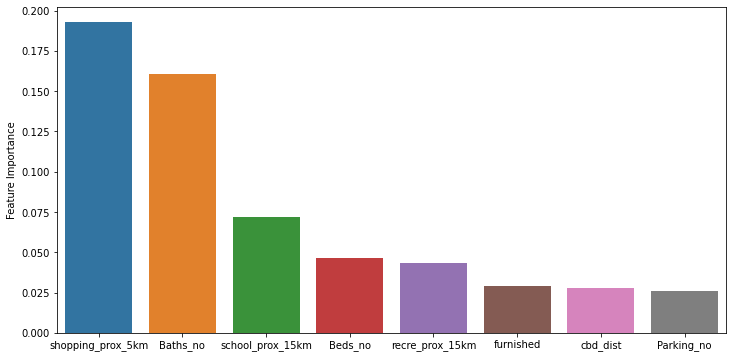

In [153]:
plt.figure(figsize=(12,6))
feat_import_plot = sns.barplot(y=feature_imp["Feature Importance"][0:8], x=feature_imp.index[0:8])

In [154]:
# These seem to be the most relevant additional features which are listed on domain and from calculated proximities
# We want to save these for summary notebook:
fig = feat_import_plot.get_figure()
fig.savefig("../plots/feat_import_external.png") 